# AI-Augmented Audit: Exploratory Data Analysis (EDA)

This notebook marks the beginning of our exploratory data analysis on the credit card fraud detection dataset. The primary goal of this phase is to understand the data structure, the distribution of its variables, and to identify the key characteristics of the business problem

## 1. Data Loading and Initial Setup

First, we import the necessary libraries and load the dataset into pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/creditcard.csv')

## 2. Target Variable Analysis (Class)

The most critical variable in our project is 'Class', which indicates whether a transaction is normal (0) or fraudulent (1). We will investigate its distribution to understand the nature of the problem.

In [2]:
# Check the distribution of the target variable
print("Class Distribution")
print(df['Class'].value_counts())
print("\n")

# Calculate the percetage of fraudulent transactions
fraud_percentage = (df['Class'].sum() / len(df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")

Class Distribution
Class
0    284315
1       492
Name: count, dtype: int64


Percentage of fraudulent transactions: 0.1727%


### Conclusion: Extreme Class Imbalance

The analisys reveals an extremely imbalanced dataset, with only **0.1727%** of transactions being fraudulent. This introduces the **Acuracy Paradox**: a model that always predicts "normal" would achieve 99.8% accuracy but would be useless in practice, as it would fail to detect any fraud. Let's quantify the financial impact of these fraudulent transactions.

In [3]:
# Calculate the total financial amount of fraudulent transactions
total_fraud_amount = df.loc[df['Class'] == 1, 'Amount'].sum()
print(f"Total amount lost to fraud in this dataset: {total_fraud_amount:,.2f}")

Total amount lost to fraud in this dataset: 60,127.97


## 3. Analysis of the Amount Feature

Next, we'll investigate the distribution of transactions amounts to understand the typical financial behavior of users.

In [4]:
# Statistical summary of the 'Amount' column
print("Statistical Summary of Amount:")
print(df['Amount'].describe())


Statistical Summary of Amount:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


In [5]:
# Sum the 'Value' column where 'Category' is 'A'
df.loc[df['Class'] == 1, 'Amount'].sum()

np.float64(60127.97)

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


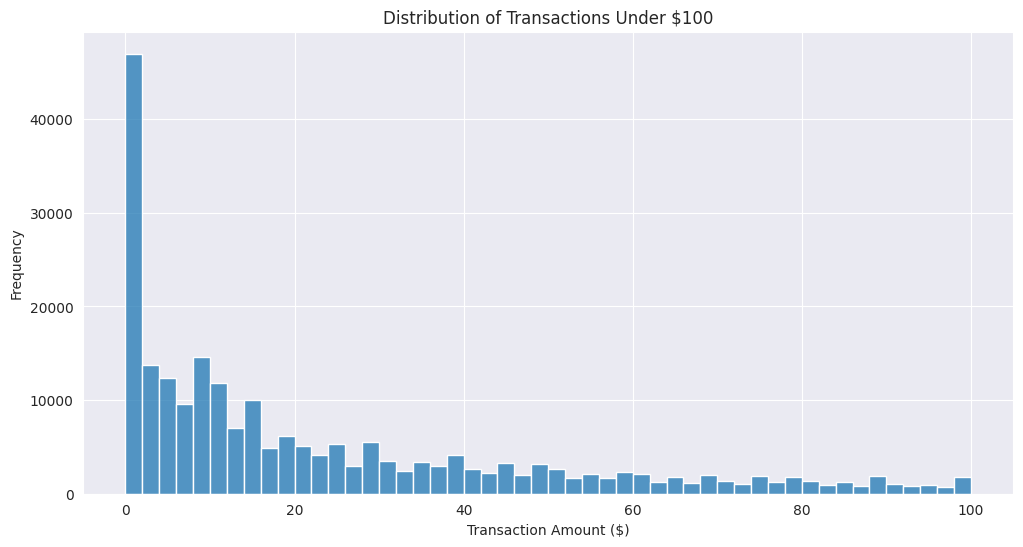

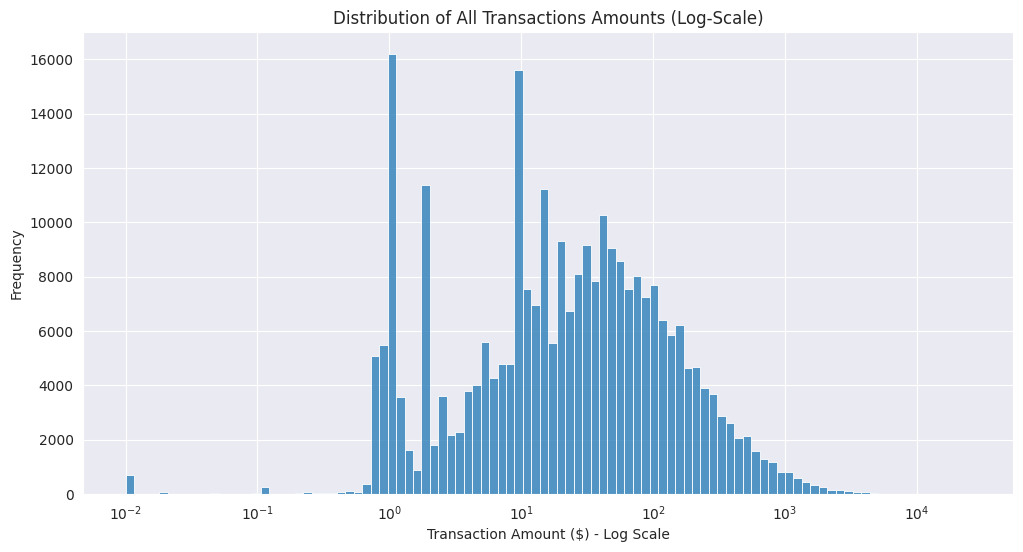

In [6]:
# Descriptive statistics for numerical columns
print(df['Amount'].describe())

# Distribution of transactions under $100
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
# Filtered df
filtered_df = df[df['Amount'] < 100]['Amount']
sns.histplot(data=filtered_df, bins=50)
plt.title("Distribution of Transactions Under $100")
plt.xlabel("Transaction Amount ($)")
plt.ylabel('Frequency')
plt.show()

# Distribution of all transactions (log scale)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Amount', bins=100, log_scale=True)
plt.title("Distribution of All Transactions Amounts (Log-Scale)")
plt.xlabel("Transaction Amount ($) - Log Scale")
plt.ylabel('Frequency')
plt.show()

### Conclusion: `Amount` Distribution

The statistical summary (`mean > median`) and the histograms confirm that the vast majority of transactions are very low value, typically under $20. There are significant outliers with extremely high values, causing strong right-skew in the distribution. The logarithmic scale is essential to visualize the massive concentration of low-value transactions.

## 4. Analisys of the `Time` Feature

Next, we analyze the `Time` feature, which represents the seconds elapsed since the first transaction over 48-hour period.

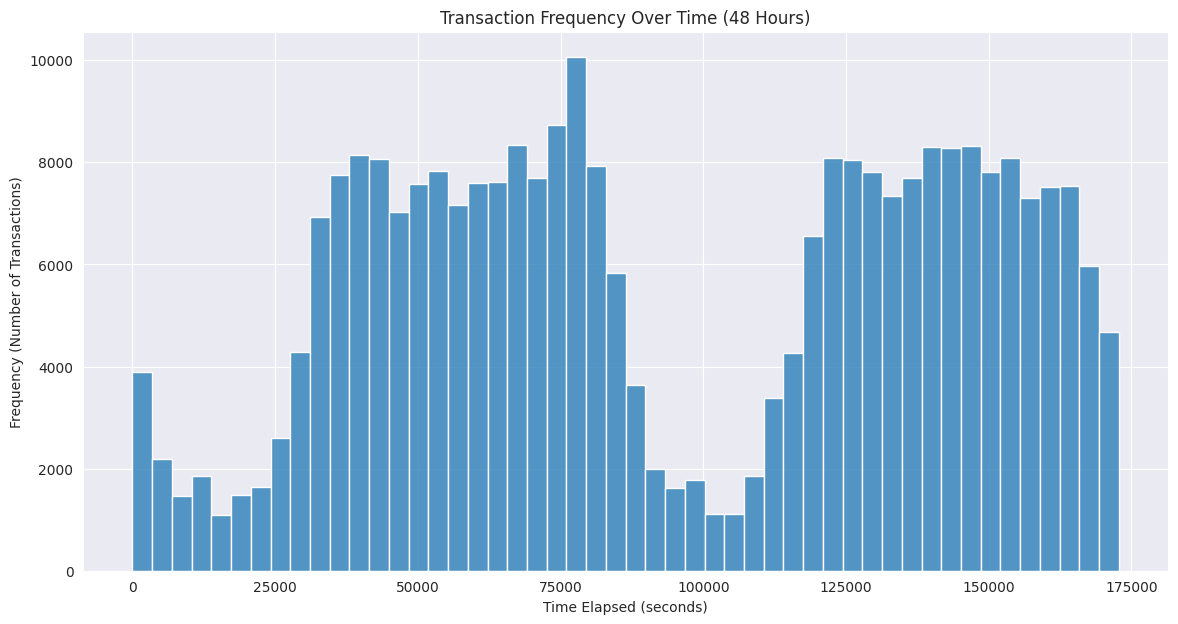

In [7]:
# Set the visual style
sns.set_style('darkgrid')

# Plot the histogram for the `Time` feature
plt.figure(figsize=(14, 7))
sns.histplot(data=df['Time'], bins=50)
plt.title("Transaction Frequency Over Time (48 Hours)")
plt.xlabel("Time Elapsed (seconds)")
plt.ylabel('Frequency (Number of Transactions)')
plt.show()

### Conclusion: `Time` Distribution

The histogram shows a clear pattern for the `Time` feature.

* **"What I See"**: The graph has two big "groups" of activity (peaks) and two very low points (valleys).
* **"What It Means"**: This pattern shows a 48-hour (2-day) cycle. The peaks are the "daytime," when many people are shopping. The valleys are the "nighttime," when most people are asleep.
* **"Why It Matters"**: This is very useful. It means the *time* of a transaction is important. A transaction in the middle of the night (a valley) looks more suspicious than a transaction during the day (a peak). Our next step is to check if the fraud rate is truly higher during the night.

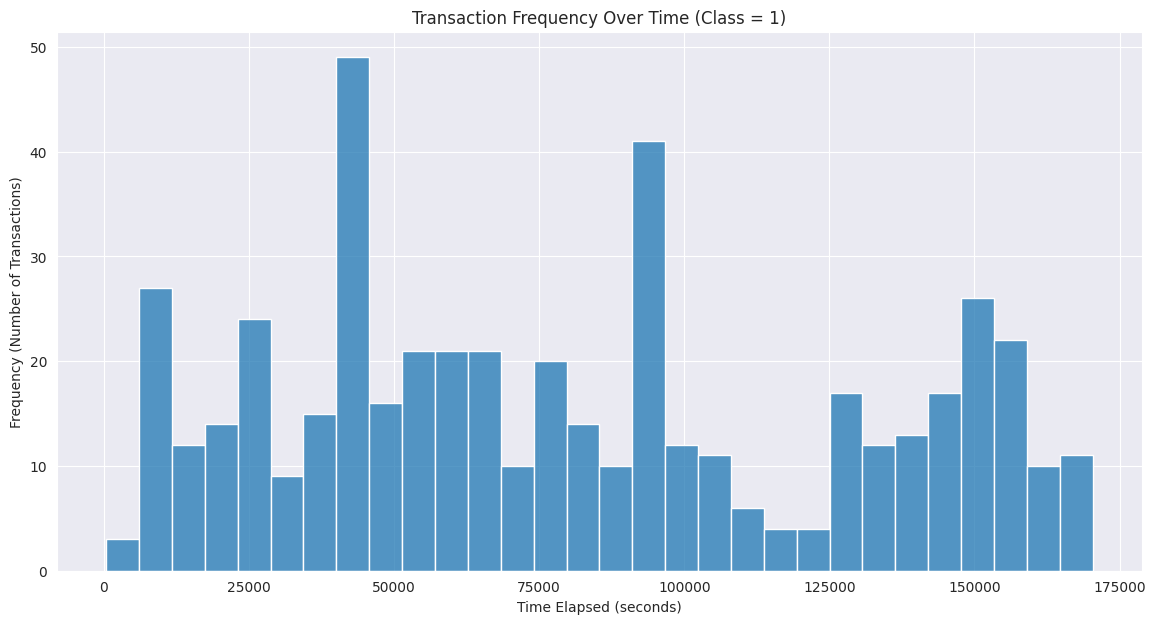

In [8]:
# Set the visual style
sns.set_style('darkgrid')

# Plot the histogram
plt.figure(figsize=(14, 7))
# Filtered df
condition = df[df['Class'] == 1]['Time']
sns.histplot(data=condition, bins=30)
plt.title("Transaction Frequency Over Time (Class = 1)")
plt.xlabel("Time Elapsed (seconds)")
plt.ylabel("Frequency (Number of Transactions)")
plt.show()

### Conclusion: Fraud vs. Time

* **"What I See"**: The "day/night" cycle pattern from the first graph is gone. Fraud transactions are more spread out across all hours.
* **"What It Means"**: This is different from the first "Time" graph. Normal transactions stop at night (the "valleys"). But fraud transactions do not stop.
* **"Why It Matters"**: This is a very strong clue. If a transaction happens at night (in a "valley"), it is very suspicious. Why? Because almost all normal transactions are gone, but the fraud is still active. This means the *chance* of a nighttime transaction being fraud is much higher.

## 4b. Calculate Day vs. Night Fraud Rates

To prove our hypotesis, we'll create a new column `is_day`. We'll label transaction as "night" (0) or "day" (1) based on time.

The "night" valleys are approximately:
* Night 1: 0s to 30,000s,
* Night 2: 85,000s to 115,000s

In [9]:
# Define the contitions
conditions = [
    (df['Time'] < 30000), # night1
    (df['Time'] >= 30000) & (df['Time'] < 85000), # day1
    (df['Time'] >= 85000) & (df['Time'] <= 115000), # night2
    (df['Time'] > 115000), # day2
]

# Define the values for each condition (0: night and 1: day)
values = [0, 1, 0, 1]

# Create a new column
df['is_day'] = np.select(conditions, values)

# Check the counts
print(df['is_day'].value_counts())

is_day
1    246326
0     38481
Name: count, dtype: int64


## 4c. Final Conclusion on Time Analisys

Now we can calculate the exact fraud rates for day vs. night.

In [10]:
# Calculate total of transactions for day/night
day_transactions = df['is_day'].sum()
night_transactions = len(df) - day_transactions

# Calculate fraud transactions day/night
fraud_by_period = df.groupby('is_day')['Class'].sum()

night_fraud_transactions = fraud_by_period[0] # is_day == 0 (night)
day_fraud_transactions = fraud_by_period[1] # is_day == 1 (day)

# Calculate the fraud rates
rate_fraud_day = day_fraud_transactions / day_transactions * 100
rate_fraud_night = night_fraud_transactions / night_transactions * 100

# Print results
print(f"Total Day Transactions: {day_transactions:,.0f}")
print(f"Total Night Transactions: {night_transactions:,.0f}")
print(f"Total Day Fraud: {day_fraud_transactions:,.0f}")
print(f"Total Night Fraud: {night_fraud_transactions:,.0f}")
print()
print(f"Fraud Day (Rate) {rate_fraud_day:,.2f}%")
print(f"Fraud Night (Rate) {rate_fraud_night:,.2f}%")

Total Day Transactions: 246,326
Total Night Transactions: 38,481
Total Day Fraud: 322
Total Night Fraud: 170

Fraud Day (Rate) 0.13%
Fraud Night (Rate) 0.44%


## Final Conclusion: Time is a Key Predictor 

* **"What I see"**: The fraud rate during the day is 0.13%. The fraud rate at night is 0.44%
* **"What It means"**: A transaction that happens at 'night' is more than 3 times as likely to be fraudulent as a transaction during the 'day'.
* **"Why It Matters"**: The `Time` feature is a strong predictor of fraud. 

## 5. Analysis of Anonymous Features


In [ ]:
# df filtered by class == 1 & class = 0 by feature V1
v1_class1 = df[df['Class'] == 1]['V1']
v1_class0 = df[df['Class'] == 0]['V1']
# print results
print(f"Feature V1: Fraudulent Transactions\n {v1_class1}")
print()
print(f"Feature V1: Normal Transactions\n {v1_class0}")

Feature V1: Fraudulent Transactions
 541      -2.312227
623      -3.043541
4920     -2.303350
6108     -4.397974
6329      1.234235
            ...   
279863   -1.927883
280143    1.378559
280149   -0.676143
281144   -3.113832
281674    1.991976
Name: V1, Length: 492, dtype: float64

Feature V1: Normal Transactions
 0         -1.359807
1          1.191857
2         -1.358354
3         -0.966272
4         -1.158233
            ...    
284802   -11.881118
284803    -0.732789
284804     1.919565
284805    -0.240440
284806    -0.533413
Name: V1, Length: 284315, dtype: float64


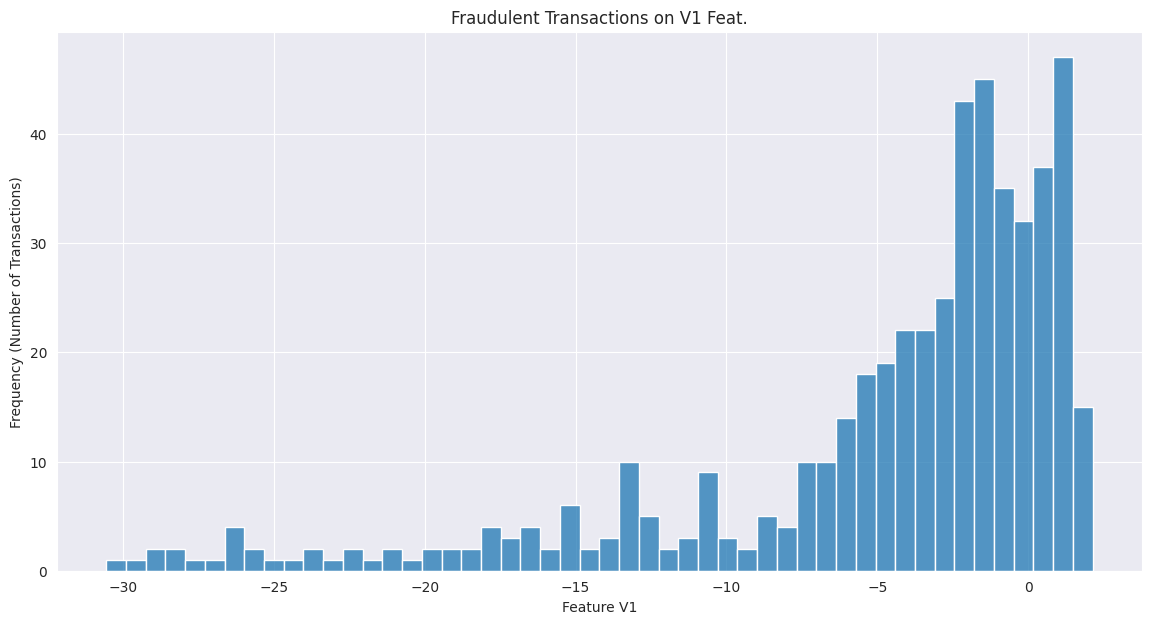

In [24]:
# set the visual style
sns.set_style('darkgrid')
# Plot the histogram for the `V1` feature (fraud: `Class` == 1)
plt.figure(figsize=(14, 7))
sns.histplot(v1_class1, bins=50)
plt.title("Fraudulent Transactions on V1 Feat.")
plt.xlabel("Feature V1")
plt.ylabel("Frequency (Number of Transactions)")
plt.show()

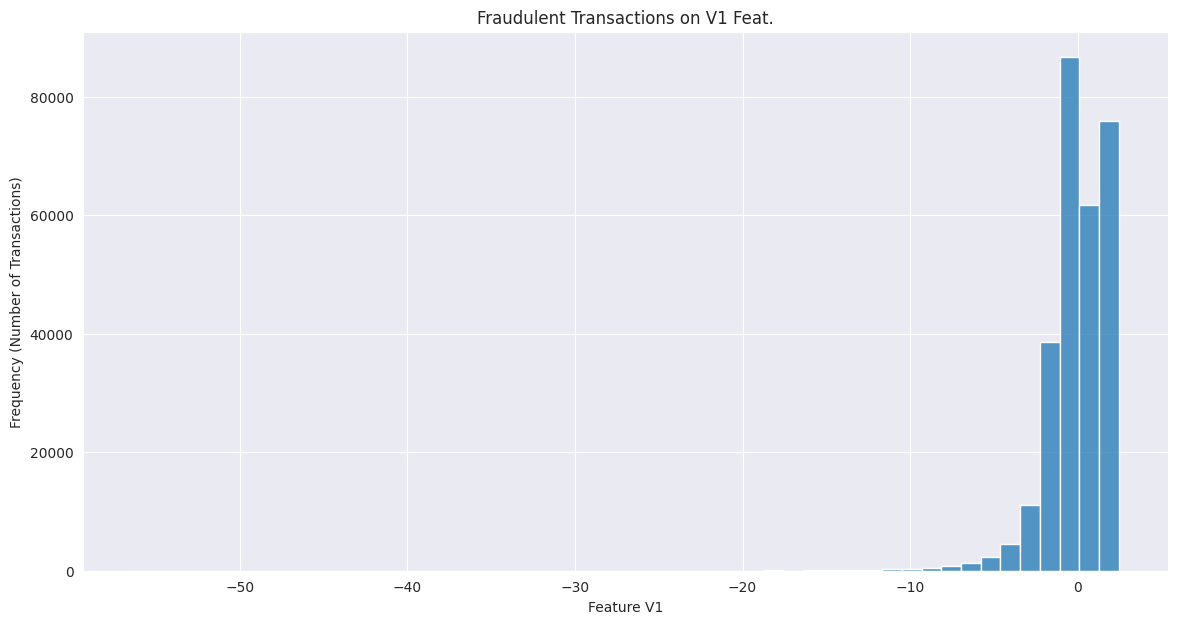

In [ ]:
# set the visual style
sns.set_style('darkgrid')
# Plot the histogram for the `V1` feature (fraud: `Class` == 0)
plt.figure(figsize=(14, 7))
sns.histplot(v1_class0, bins=50)
plt.title("Normal Transactions on V1 Feat.")
plt.xlabel("Feature V1")
plt.ylabel("Frequency (Number of Transactions)")
plt.show()